# Count number of items on image
Distribution centers often use robots to move objects as a part of their operations. Objects are carried in bins which can contain multiple objects. In this project, you will have to build a model that can count the number of objects in each bin. A system like this can be used to track inventory and make sure that delivery consignments have the correct number of items.

## Workspace set-up, dependencies and reuired packages

In [55]:
!pip install smdebug torch torchvision tqdm --no-cache-dir

In [56]:
import sagemaker
import boto3

In [57]:
# General macros
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-355010557234
AWS Region: us-east-1
RoleArn: arn:aws:iam::355010557234:role/service-role/AmazonSageMaker-ExecutionRole-20220416T203823


## Data Preparation
The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [8]:
local_data_path = "train_data"

In [7]:
# Warning - downloading is time and resource consuming. You can be charged for that
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data(local_data_path):
    s3_client = boto3.client('s3')
    with open('file_list.json', 'r') as f:
        d=json.load(f)
    for k, v in d.items():
        print(f"Downloading Images with {k} objects from")
        directory=os.path.join(local_data_path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

            
download_and_arrange_data(local_data_path)

  0%|          | 1/1228 [00:00<02:47,  7.33it/s]

  0%|          | 1/2299 [00:00<04:30,  8.49it/s]

  0%|          | 2/2666 [00:00<03:41, 12.04it/s]

  0%|          | 0/2373 [00:00<?, ?it/s]

  0%|          | 1/1875 [00:00<04:00,  7.80it/s]

100%|██████████| 1875/1875 [02:31<00:00, 12.40it/s]


## Dataset
Cell above downloaded multiple images with differen numbers of objects in bins: {1,2,3,4,5}.
The full dataset is avaiable [here](https://registry.opendata.aws/amazon-bin-imagery/).

### Dataset information

In [50]:
# Print statistics about the dataset
import os

main_dirs = os.listdir(local_data_path)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(local_data_path, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'There are {num_items[directory]} images with {directory} items in it.')

There are 1228 images with 1 items in it.
There are 2299 images with 2 items in it.
There are 2666 images with 3 items in it.
There are 2373 images with 4 items in it.
There are 1875 images with 5 items in it.


In [33]:
print(num_items.keys())

dict_keys(['1', '2', '3', '4', '5'])


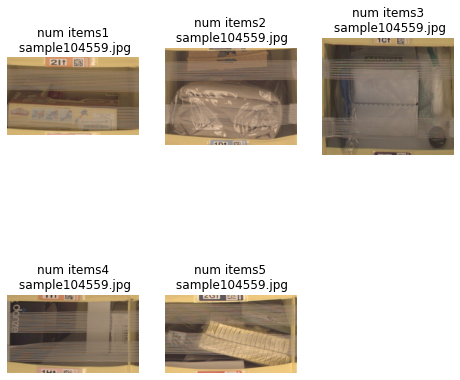

In [39]:
# Plot some of the data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2
for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample"+ img_path
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(local_data_path, key, img_filename)).squeeze(), cmap="gray")
plt.show()
figure.savefig('sample_dataset_images.png')

### Dataset division into test-valid-train
Train: 60%, Test: 20%, Valid: 40%

In [51]:
# Select files for each collection
file_list_train = {}
file_list_test = {}
file_list_valid = {}
for key in num_items.keys():
    valid_no = int(0.2*num_items[key])
    test_no = int(0.2*num_items[key])
    train_no =  int(num_items[key] - test_no - valid_no)
    file_list_valid[key] = []
    file_list_test[key] = []
    file_list_train[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if idx < valid_no:
            file_list_valid[key].append(filename)
        elif (idx >= valid_no and idx<(test_no+valid_no)):
            file_list_test[key].append(filename)
        else:
            file_list_train[key].append(filename)
            
    print(f'num items {key}: Valid: {valid_no}, Test: {test_no}, Train: {train_no}')

num items 1: Valid: 245, Test: 245, Train: 738
num items 2: Valid: 459, Test: 459, Train: 1381
num items 3: Valid: 533, Test: 533, Train: 1600
num items 4: Valid: 474, Test: 474, Train: 1425
num items 5: Valid: 375, Test: 375, Train: 1125


In [54]:
import shutil
import os

subdivided_localdata_path = 'data_divided'

try:
    os.mkdir(subdivided_localdata_path)
    os.mkdir(os.path.join(subdivided_localdata_path, 'valid'))
    os.mkdir(os.path.join(subdivided_localdata_path, 'test'))
    os.mkdir(os.path.join(subdivided_localdata_path, 'train'))
except OSError as error:
    print(error)   

for key in num_items.keys():
    try:
        os.mkdir(os.path.join(subdivided_localdata_path, 'valid', key))
        os.mkdir(os.path.join(subdivided_localdata_path, 'test', key))
        os.mkdir(os.path.join(subdivided_localdata_path, 'train', key))
    except OSError as error:
        print(error)
        
    for filename in file_list_valid[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(subdivided_localdata_path,'valid', key, filename))
    for filename in file_list_test[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(subdivided_localdata_path,'test', key, filename))
    for filename in file_list_train[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(subdivided_localdata_path,'train', key, filename))
        
        
print('Copy completed')

[Errno 17] File exists: 'data_divided'
[Errno 17] File exists: 'data_divided/valid/1'


### Upload dataset to S3

In [65]:
# Warning - uploading is time and resource consuming. You can be charged for that
import os
bucket_path = "s3://"+ bucket
database_path = os.path.join(bucket_path, subdivided_localdata_path)
print(f"Path to used bucket: {bucket_path}")
print(f"Path to dataset in S3: {database_path}")

Path to used bucket: s3://sagemaker-us-east-1-355010557234
Path to dataset in S3: s3://sagemaker-us-east-1-355010557234/data_divided


In [ ]:
os.environ["DATABASE_PATH"] = database_path
os.environ["DATABASE_ORIGIN_PATH"] = subdivided_localdata_path
!aws s3 sync ${DATABASE_ORIGIN_PATH} ${DATABASE_PATH}

## Model Training
Here we train the model.
1. First we tune hyperparameters
1. Secondly we train using identified parameters (with optional concurrency)
1. Third, we deploy the model and perform a simple inference

**Info** This code utilizes multiple `*.py` files. 

In [ ]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances